# TODOs:

- final train and val loss (best)

# Google colab initialization

For Google colab uncomment these lines and run them to access your drive or try the second way (not tested)

In [51]:
import pandas as pd

USE_COLAB = True

if USE_COLAB:
    from google.colab import drive

    drive.mount('/content/drive')
    import sys

    sys.path.insert(1, r'/content/drive/My Drive/')

ModuleNotFoundError: No module named 'google.colab'

In [52]:
# Other try
# !git clone https://github.com/Alexanderstaehle/OM_project

In [53]:
# import sys
# sys.path.append("OM_project")

# Imports and Setup

In [104]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from utils import ml_utils, visualization, data_loading, tf_models

In [105]:
RETRAIN_FLAG = True

In [106]:
filename_bs = lambda bs: ml_utils.path_from_filename(f'model_fixed_lr_diff_bs_{bs}', format_="tf")
filename_bs_lr = lambda bs, lr: ml_utils.path_from_filename(f'model_lr_{lr}_diff_bs_{bs}', format_="tf")

In [107]:
filename_bs_opt_sam = lambda bs, opt, sam: ml_utils.path_from_filename(
    f'model_fixed_lr_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")
filename_bs_lr_opt_sam = lambda bs, lr, opt, sam: ml_utils.path_from_filename(
    f'model_lr_{lr}_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")

In [108]:
def build_and_load_sam_model_weights(train, optimizer, filename, adaptive=False, rho=0.05):
    model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive, rho)
    model.load_weights(filename)
    return model

In [109]:
def build_and_load_model_weights(train, optimizer, filename):
    model = tf_models.build_and_compile_simple_cnn(train, optimizer)
    model.load_weights(filename)
    return model

In [110]:
def callback_for_filename(filename):
    train_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filename,
            monitor='val_loss',
            mode='min',
            verbose=1,
            save_best_only=True,
            save_weights_only=True
        )
    ]

    return train_callbacks

In [111]:
data_loading.initialize_env()
sns.set_theme()
color_map = sns.color_palette(as_cmap=True)
ml_utils.check_tpu_gpu()
# dataset_name = 'MNIST'
dataset_name = 'Fashion_MNIST'
EPOCHS = 500

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Number of accelerators:  1


In [112]:
models = {}
models_states = {}
sharpnesses = ml_utils.init_sharpnesses_dict()
initial_weights = ml_utils.init_initial_weights_dict()

# Different batch sizes with fixed learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM

In [113]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'sgd', 'sam')

In [114]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))
        models[key + (batch_size,)] = model

In [115]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-24 19:25:58.231197: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/5
1491/1500 [============================>.] - ETA: 0s - loss: 0.9688 - accuracy: 0.6306

2022-02-24 19:26:04.823565: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.58819, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 8s 5ms/step - loss: 0.9666 - accuracy: 0.6312 - val_loss: 0.5882 - val_accuracy: 0.7917
Epoch 2/5
1493/1500 [============================>.] - ETA: 0s - loss: 0.5807 - accuracy: 0.7709
Epoch 2: val_loss improved from 0.58819 to 0.47500, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 4ms/step - loss: 0.5804 - accuracy: 0.7711 - val_loss: 0.4750 - val_accuracy: 0.8337
Epoch 3/5
1492/1500 [============================>.] - ETA: 0s - loss: 0.5038 - accuracy: 0.8019
Epoch 3: val_loss improved from 0.47500 to 0.42742, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 4ms/step - loss: 0.5034 - accuracy: 0.8021 - val_loss: 0.4274 - val_accuracy: 0.8512
Epoch 4/5
1490/1500 [==========================

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-24 19:26:33.134392: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/5
744/750 [============================>.] - ETA: 0s - loss: 1.2430 - accuracy: 0.5277

2022-02-24 19:26:37.063554: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.70132, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 5s 5ms/step - loss: 1.2388 - accuracy: 0.5292 - val_loss: 0.7013 - val_accuracy: 0.7639
Epoch 2/5
742/750 [============================>.] - ETA: 0s - loss: 0.6951 - accuracy: 0.7294
Epoch 2: val_loss improved from 0.70132 to 0.57597, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.6941 - accuracy: 0.7297 - val_loss: 0.5760 - val_accuracy: 0.7947
Epoch 3/5
744/750 [============================>.] - ETA: 0s - loss: 0.5924 - accuracy: 0.7676
Epoch 3: val_loss improved from 0.57597 to 0.50827, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.5918 - accuracy: 0.7678 - val_loss: 0.5083 - val_accuracy: 0.8200
Epoch 4/5
741/750 [============================>.] - ETA:

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-24 19:26:54.059461: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/5
374/375 [============================>.] - ETA: 0s - loss: 1.4286 - accuracy: 0.4606

2022-02-24 19:26:58.342137: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.81519, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 5s 9ms/step - loss: 1.4268 - accuracy: 0.4612 - val_loss: 0.8152 - val_accuracy: 0.7138
Epoch 2/5
373/375 [============================>.] - ETA: 0s - loss: 0.8039 - accuracy: 0.6879
Epoch 2: val_loss improved from 0.81519 to 0.67264, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.8033 - accuracy: 0.6882 - val_loss: 0.6726 - val_accuracy: 0.7736
Epoch 3/5
374/375 [============================>.] - ETA: 0s - loss: 0.6945 - accuracy: 0.7320
Epoch 3: val_loss improved from 0.67264 to 0.60986, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.6941 - accuracy: 0.7322 - val_loss: 0.6099 - val_accuracy: 0.7882
Epoch 4/5
373/375 [============================>.] - E

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-24 19:27:11.276144: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/5
186/188 [============================>.] - ETA: 0s - loss: 1.9668 - accuracy: 0.3541

2022-02-24 19:27:15.555427: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 1.12079, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 5s 15ms/step - loss: 1.9605 - accuracy: 0.3555 - val_loss: 1.1208 - val_accuracy: 0.6469
Epoch 2/5
186/188 [============================>.] - ETA: 0s - loss: 0.9806 - accuracy: 0.6023
Epoch 2: val_loss improved from 1.12079 to 0.80269, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.9795 - accuracy: 0.6028 - val_loss: 0.8027 - val_accuracy: 0.7205
Epoch 3/5
186/188 [============================>.] - ETA: 0s - loss: 0.8295 - accuracy: 0.6777
Epoch 3: val_loss improved from 0.80269 to 0.71841, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.8288 - accuracy: 0.6781 - val_loss: 0.7184 - val_accuracy: 0.7552
Epoch 4/5
186/188 [============================>.] 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-24 19:27:26.489209: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/5
94/94 [==============================] - ETA: 0s - loss: 2.2658 - accuracy: 0.1875

2022-02-24 19:27:29.018315: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.20263, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 3s 26ms/step - loss: 2.2658 - accuracy: 0.1875 - val_loss: 2.2026 - val_accuracy: 0.3728
Epoch 2/5
94/94 [==============================] - ETA: 0s - loss: 2.0455 - accuracy: 0.4154
Epoch 2: val_loss improved from 2.20263 to 1.66869, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 2.0455 - accuracy: 0.4154 - val_loss: 1.6687 - val_accuracy: 0.5748
Epoch 3/5
94/94 [==============================] - ETA: 0s - loss: 1.2297 - accuracy: 0.5623
Epoch 3: val_loss improved from 1.66869 to 0.91400, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 1.2297 - accuracy: 0.5623 - val_loss: 0.9140 - val_accuracy: 0.6933
Epoch 4/5
94/94 [==============================] - ETA: 0s - 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-24 19:27:39.011878: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/5
47/47 [==============================] - ETA: 0s - loss: 2.2642 - accuracy: 0.1389

2022-02-24 19:27:41.533040: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.20089, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 3s 54ms/step - loss: 2.2642 - accuracy: 0.1389 - val_loss: 2.2009 - val_accuracy: 0.2371
Epoch 2/5
47/47 [==============================] - ETA: 0s - loss: 2.1297 - accuracy: 0.2597
Epoch 2: val_loss improved from 2.20089 to 1.98463, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 2.1297 - accuracy: 0.2597 - val_loss: 1.9846 - val_accuracy: 0.3422
Epoch 3/5
47/47 [==============================] - ETA: 0s - loss: 1.7642 - accuracy: 0.4867
Epoch 3: val_loss improved from 1.98463 to 1.41514, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 1.7642 - accuracy: 0.4867 - val_loss: 1.4151 - val_accuracy: 0.6011
Epoch 4/5
47/47 [==============================] - ETA: 0s

In [116]:
fixed_lr_state_filename = 'model_fixed_lr_diff_bs_state'

In [117]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], fixed_lr_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(fixed_lr_state_filename)

In [118]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate', 'fixed_lr_diff_bs_SGD_SAM')

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

#### Sharpness

In [119]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

2022-02-24 19:27:51.319914: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.3821 - accuracy: 0.8688
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.82104D-01    |proj g|=  1.48432D-02
47/47 [==============================] - 1s 11ms/step - loss: 10.9006 - accuracy: 0.2934

At iterate    1    f= -1.09006D+01    |proj g|=  2.96863D-02
  ys=-9.166E+02  -gs= 1.795E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 32.0581 - accuracy: 0.1501

At iterate    2    f= -3.20581D+01    |proj g|=  2.61104D-02
  ys=-1.157E+03  -gs= 4.278E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 10ms/step - loss: 43.2347 - accuracy: 0.0998

At iterate    3    f= -4.32347D+01    |proj g|=  2.57211D-02
  ys=-3.584E+02  -gs= 2.484E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 44.5864 - ac


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 45.9205 - accuracy: 0.0998



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-24 19:28:17.384327: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     12  70282     8 56775   2.116D-02  -4.592D+01
  F =  -45.920604705810547     

ABNORMAL_TERMINATION_IN_LNSRCH                              
47/47 [==============================] - 1s 13ms/step - loss: 0.4465 - accuracy: 0.8459
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.46456D-01    |proj g|=  1.45990D-02
47/47 [==============================] - 1s 11ms/step - loss: 13.4400 - accuracy: 0.1292

At iterate    1 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 48.1075 - accuracy: 0.0998

At iterate    8    f= -4.81075D+01    |proj g|=  2.19833D-02
47/47 [==============================] - 1s 11ms/step - loss: 48.1077 - accuracy: 0.0998

At iterate    9    f= -4.81077D+01    |proj g|=  2.19628D-02
  ys=-1.191E-05  -gs= 7.254E-03 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 48.1078 - accuracy: 0.0998

At iterate   10    f= -4.81078D+01    |proj g|=  2.19425D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     12  65457     7 53216   2.194D-02  -4.811D+01
  F =  -48.1

2022-02-24 19:28:44.507801: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.5334 - accuracy: 0.8130
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33446D-01    |proj g|=  1.37752D-02
47/47 [==============================] - 1s 13ms/step - loss: 8.7002 - accuracy: 0.2440

At iterate    1    f= -8.70018D+00    |proj g|=  2.75503D-02
  ys=-4.751E+02  -gs= 3.640E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 37.2603 - accuracy: 0.1684

At iterate    2    f= -3.72603D+01    |proj g|=  2.29038D-02
  ys=-1.763E+03  -gs= 5.077E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 51.3132 - accuracy: 0.0998

At iterate    3    f= -5.13132D+01    |proj g|=  2.21994D-02
  ys=-3.611E+02  -gs= 4.706E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 56.7966 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 13ms/step - loss: 56.7894 - accuracy: 0.0998

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      7      9  72643     5 55509   2.184D-02  -5.702D+01
  F =  -57.022949218750000     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-24 19:29:05.782656: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 10ms/step - loss: 0.6268 - accuracy: 0.7892
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.26811D-01    |proj g|=  1.28521D-02
47/47 [==============================] - 1s 11ms/step - loss: 3.2911 - accuracy: 0.2410

At iterate    1    f= -3.29115D+00    |proj g|=  2.55363D-02
  ys=-8.369E+01  -gs= 1.766E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 27.7148 - accuracy: 0.1766

At iterate    2    f= -2.77148D+01    |proj g|=  2.57041D-02
  ys=-1.718E+03  -gs= 3.084E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 44.5194 - accuracy: 0.1902

At iterate    3    f= -4.45194D+01    |proj g|=  2.22757D-02
  ys=-5.986E+02  -gs= 5.089E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 10ms/step - loss: 46.9818 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 48.9932 - accuracy: 0.1950

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      9     11  75709     7 56253   3.362D-03  -4.899D+01
  F =  -48.993171691894531     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-24 19:29:30.667466: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.7575 - accuracy: 0.7512
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57471D-01    |proj g|=  1.27845D-02
47/47 [==============================] - 1s 11ms/step - loss: 4.3708 - accuracy: 0.2079

At iterate    1    f= -4.37081D+00    |proj g|=  2.55690D-02
  ys=-7.075E+01  -gs= 2.855E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 29.1616 - accuracy: 0.1931

At iterate    2    f= -2.91616D+01    |proj g|=  2.39305D-02
  ys=-1.415E+03  -gs= 4.764E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 10ms/step - loss: 38.7175 - accuracy: 0.1931

At iterate    3    f= -3.87175D+01    |proj g|=  2.16853D-02
  ys=-3.400E+02  -gs= 3.038E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 39.7317 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-24 19:29:55.719686: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.8996 - accuracy: 0.6743
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.99626D-01    |proj g|=  1.26154D-02
47/47 [==============================] - 1s 13ms/step - loss: 7.5506 - accuracy: 0.2630

At iterate    1    f= -7.55060D+00    |proj g|=  2.52308D-02
  ys=-1.924E+02  -gs= 6.021E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 29.6365 - accuracy: 0.2852

At iterate    2    f= -2.96365D+01    |proj g|=  2.27951D-02
  ys=-1.097E+03  -gs= 5.133E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 36.9687 - accuracy: 0.2829

At iterate    3    f= -3.69687D+01    |proj g|=  2.16354D-02
  ys=-3.614E+02  -gs= 1.831E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 37.7793 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


59786      7      8  69265     6 55090   1.708D-03  -3.856D+01
  F =  -38.562416076660156     

ABNORMAL_TERMINATION_IN_LNSRCH                              


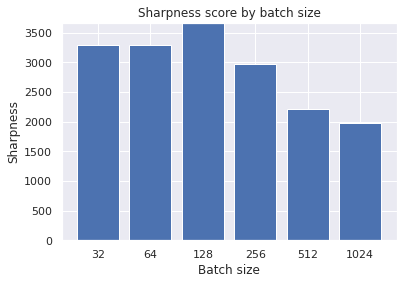

In [120]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


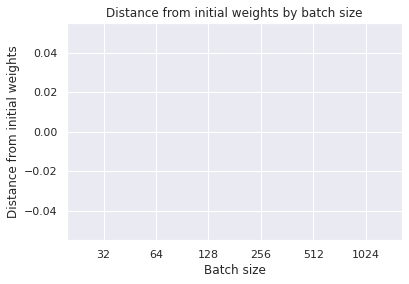

<Figure size 432x288 with 0 Axes>

In [121]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [122]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  6.868595314025879
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  27.735214710235596
Batch size:  64
	Mean time per epoch:  4.081904792785645
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  16.400123357772827
Batch size:  128
	Mean time per epoch:  3.339431953430176
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  13.72858190536499
Batch size:  256
	Mean time per epoch:  2.9288652896881104
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  12.193986654281616
Batch size:  512
	Mean time per epoch:  2.3830679416656495
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  9.718336343765259
Batch size:  1024
	Mean time per epoch:  2.269138956069946
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  9.262920379638672


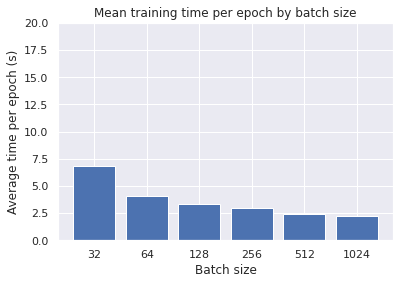

In [123]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

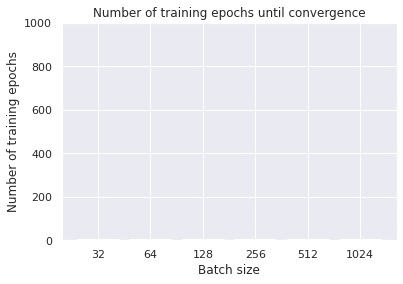

In [124]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

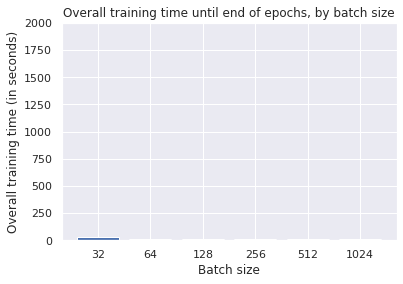

In [125]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

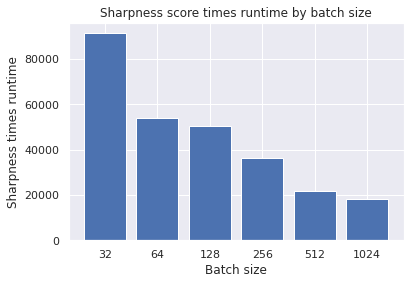

In [127]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### SGD with Momentum + ASAM

In [95]:
models_dict_fixed_sgd_asam = {}
batch_sizes = [32, 64, 128, 256, 512, 1024]
#batch_sizes = [32]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'sgd', 'asam')

In [96]:
models_by_batch_size_fixed_lr_sgd_asam = {}

In [97]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "ASAM"))
        models_by_batch_size_fixed_lr_sgd_asam[batch_size] = model
        models[key + (batch_size,)] = model
        initial_weights[key + (batch_size,)] = model.get_weights()

In [98]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "ASAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-24 19:00:44.343015: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


1499/1500 [============================>.] - ETA: 0s - loss: 0.9652 - accuracy: 0.6265

2022-02-24 19:00:51.294123: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.57231, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 9s 5ms/step - loss: 0.9651 - accuracy: 0.6265 - val_loss: 0.5723 - val_accuracy: 0.7943
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-24 19:00:53.526278: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


741/750 [============================>.] - ETA: 0s - loss: 1.4259 - accuracy: 0.4940

2022-02-24 19:00:57.844146: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.69402, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 5s 6ms/step - loss: 1.4183 - accuracy: 0.4963 - val_loss: 0.6940 - val_accuracy: 0.7625
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-24 19:00:58.825647: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


368/375 [============================>.] - ETA: 0s - loss: 1.8270 - accuracy: 0.3619

2022-02-24 19:01:02.194149: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.89222, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 1.8108 - accuracy: 0.3666 - val_loss: 0.8922 - val_accuracy: 0.6712
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-24 19:01:03.088256: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


184/188 [============================>.] - ETA: 0s - loss: 2.1166 - accuracy: 0.3226

2022-02-24 19:01:06.906973: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 1.46472, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 4s 15ms/step - loss: 2.1068 - accuracy: 0.3264 - val_loss: 1.4647 - val_accuracy: 0.5669
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-24 19:01:07.773699: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


94/94 [==============================] - ETA: 0s - loss: 2.2598 - accuracy: 0.2289

2022-02-24 19:01:10.348680: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.15743, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 3s 27ms/step - loss: 2.2598 - accuracy: 0.2289 - val_loss: 2.1574 - val_accuracy: 0.3121
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-24 19:01:11.155950: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


46/47 [============================>.] - ETA: 0s - loss: 2.2959 - accuracy: 0.0659

2022-02-24 19:01:14.698916: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.23963, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 4s 52ms/step - loss: 2.2952 - accuracy: 0.0665 - val_loss: 2.2396 - val_accuracy: 0.1185


In [99]:
fixed_lr_sgd_asam_state_filename = 'model_fixed_lr_diff_bs_sgd_asam_state'

In [100]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], fixed_lr_sgd_asam_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(fixed_lr_sgd_asam_state_filename)

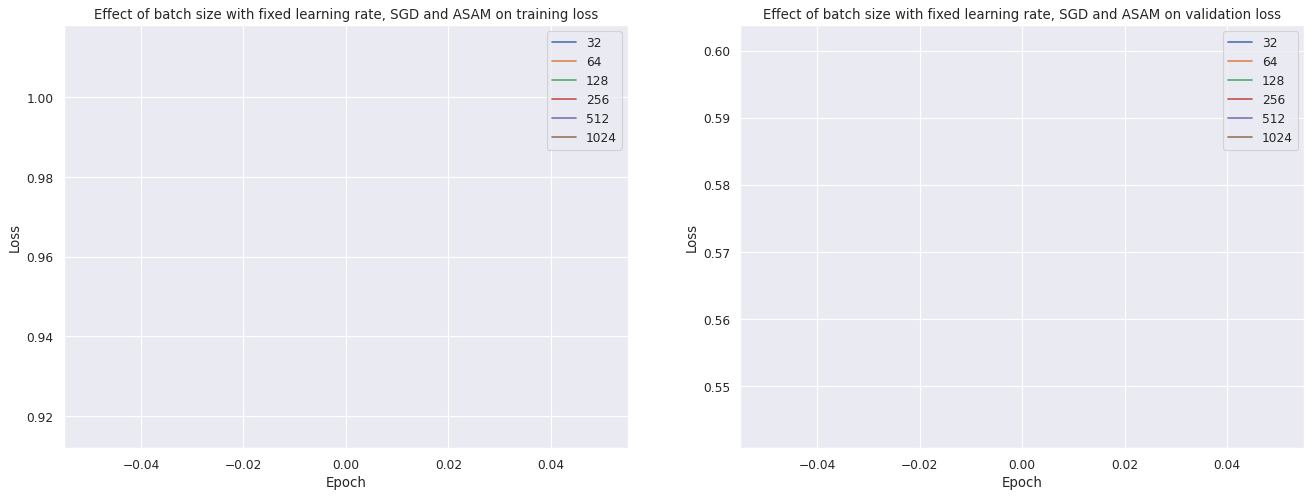

In [101]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, SGD and ASAM',
                                 'model_fixed_lr_diff_bs_sgd_asam_state')

#### Sharpness

In [102]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

2022-02-24 19:01:15.963502: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.5798 - accuracy: 0.7921
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.79830D-01    |proj g|=  1.27983D-02
47/47 [==============================] - 1s 11ms/step - loss: 5.0367 - accuracy: 0.3887

At iterate    1    f= -5.03668D+00    |proj g|=  2.55966D-02
  ys=-2.131E+02  -gs= 5.122E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 31.0837 - accuracy: 0.2661

At iterate    2    f= -3.10837D+01    |proj g|=  2.28635D-02
  ys=-1.721E+03  -gs= 3.764E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 40.2201 - accuracy: 0.2505

At iterate    3    f= -4.02201D+01    |proj g|=  2.27585D-02
  ys=-1.814E+02  -gs= 3.308E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 41.3529 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 49.7635 - accuracy: 0.1950

At iterate    8    f= -4.97635D+01    |proj g|=  4.19821D-03
12/47 [======>.......................] - ETA: 0s - loss: 49.9014 - accuracy: 0.1927


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 49.7635 - accuracy: 0.1950

At iterate    9    f= -4.97635D+01    |proj g|=  3.16475D-03
47/47 [==============================] - 1s 11ms/step - loss: 49.7635 - accuracy: 0.1950

At iterate   10    f= -4.97635D+01    |proj g|=  3.16475D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     13  74021     6 55068   3.165D-03  -4.976D+01
  F =  -49.763477325439453     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


2022-02-24 19:01:43.673177: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.6989 - accuracy: 0.7593
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.98927D-01    |proj g|=  1.29323D-02
47/47 [==============================] - 1s 11ms/step - loss: 7.2590 - accuracy: 0.3909

At iterate    1    f= -7.25903D+00    |proj g|=  2.58646D-02
  ys=-2.599E+02  -gs= 6.490E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 31.5397 - accuracy: 0.2934

At iterate    2    f= -3.15397D+01    |proj g|=  2.27455D-02
  ys=-1.328E+03  -gs= 4.909E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 41.7307 - accuracy: 0.2848

At iterate    3    f= -4.17307D+01    |proj g|=  2.16625D-02
  ys=-2.213E+02  -gs= 3.315E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 42.3474 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-24 19:02:05.138087: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.8958 - accuracy: 0.6676
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.95821D-01    |proj g|=  1.30624D-02
47/47 [==============================] - 1s 11ms/step - loss: 8.5385 - accuracy: 0.1706

At iterate    1    f= -8.53852D+00    |proj g|=  2.61249D-02
  ys=-2.926E+02  -gs= 1.017E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 28.6155 - accuracy: 0.1133

At iterate    2    f= -2.86155D+01    |proj g|=  2.30982D-02
  ys=-9.551E+02  -gs= 4.810E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 36.2116 - accuracy: 0.1010

At iterate    3    f= -3.62116D+01    |proj g|=  2.16826D-02
  ys=-2.484E+02  -gs= 2.512E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 38.2900 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-24 19:02:25.036928: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      8      9  76921     7 57550   2.605D-03  -4.106D+01
  F =  -41.055191040039062     

ABNORMAL_TERMINATION_IN_LNSRCH                              
47/47 [==============================] - 1s 12ms/step - loss: 1.4611 - accuracy: 0.5659
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46106D+00    |proj g|=  1.21787D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.5522 - accuracy: 0.1534

At iterate    1  

2022-02-24 19:02:49.945386: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 2.1563 - accuracy: 0.3148
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.15628D+00    |proj g|=  1.14698D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.3883 - accuracy: 0.0929

At iterate    1    f= -2.38829D+00    |proj g|=  2.29397D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.5587 - accuracy: 0.0175

At iterate    2    f= -2.55872D+00    |proj g|=  2.28413D-02
47/47 [==============================] - 1s 10ms/step - loss: 2.5676 - accuracy: 0.0166

At iterate    3    f= -2.56756D+00    |proj g|=  2.28348D-02
  ys=-8.370E-03  -gs= 4.111E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 2.5759 - accuracy: 0.0159

At iterate    4    f= -2.57594D+00    |proj g|=  2.28287D-02
  ys=-6.197E-03  -gs= 3.908E-01

2022-02-24 19:03:15.883668: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 2.2386 - accuracy: 0.1200
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.23858D+00    |proj g|=  1.14565D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.4860 - accuracy: 0.0015

At iterate    1    f= -2.48599D+00    |proj g|=  2.29131D-02
47/47 [==============================] - 1s 10ms/step - loss: 2.6569 - accuracy: 0.0011

At iterate    2    f= -2.65694D+00    |proj g|=  2.28301D-02
  ys=-1.583E+00  -gs= 6.988E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 3.0047 - accuracy: 5.6250e-04

At iterate    3    f= -3.00473D+00    |proj g|=  2.27727D-02
  ys=-7.454E+00  -gs= 1.292E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 3.7670 - accuracy: 3.5417e-04

At iterate    4    f= -3.76700D+

In [103]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

TypeError: plot_sharpness() missing 1 required positional argument: 'key'

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### ADAM + SAM

In [ ]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'adam', 'sam')

In [ ]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "SAM"))
        models[key + (batch_size,)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "SAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()

In [ ]:
state_filename = 'model_fixed_lr_diff_bs_adam_sam_state'

In [ ]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, ADAM and SAM',
                                 state_filename)

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### ADAM + ASAM

In [ ]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'adam', 'asam')

In [ ]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "ASAM"))
        models[key + (batch_size,)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "ASAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()

In [ ]:
state_filename = 'model_fixed_lr_diff_bs_adam_asam_state'

In [ ]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, ADAM and ASAM',
                                 state_filename)

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()


In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

## without sharpness aware minimization

### SGD with Momentum

In [ ]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'sgd', 'none')

In [ ]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "NONE"))
        models[key + (batch_size,)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "NONE"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()

In [ ]:
state_filename = 'model_fixed_lr_diff_bs_noSAM_state'

In [ ]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate without SAM',
                                 'fixed_lr_diff_bs_SGD_noSAM')

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### ADAM

In [ ]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'adam', 'none')

In [ ]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "NONE"))
        models[key + (batch_size,)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "NONE"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()

In [ ]:
state_filename = 'model_fixed_lr_diff_bs_ADAM_noSAM_state'

In [ ]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate without SAM and ADAM',
                                 'fixed_lr_diff_bs_ADAM_noSAM')

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

# Different batch sizes with linear increasing learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM

In [ ]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'sgd', 'sam')

In [ ]:
models_by_batch_size_diff_lr = {}
model_history_dict_diff_lr = {}

In [ ]:
diff_lr_state_filename = 'model_diff_lr_diff_bs_state'

In [ ]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "SAM"))
        models_by_batch_size_diff_lr[batch_size] = model
        models[key + (batch_size, lr)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "SAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()

In [ ]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], diff_lr_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(diff_lr_state_filename)

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate',
                                 'diff_lr_diff_bs')

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key, learning_rates)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### SGD with Momentum + ASAM

In [ ]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'sgd', 'asam')

In [ ]:
state_filename = 'model_diff_lr_diff_bs_sgd_asam_state'

In [ ]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "ASAM"))
        models_by_batch_size_diff_lr[batch_size] = model
        models[key + (batch_size, lr)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "ASAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()

In [ ]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with SGD and ASAM',
                                 'diff_lr_diff_bs_SGD_ASAM')

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key, learning_rates)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### ADAM + SAM

In [ ]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'adam', 'sam')

In [ ]:
state_filename = 'model_diff_lr_diff_bs_adam_sam_state'

In [ ]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "SAM"))
        models_by_batch_size_diff_lr[batch_size] = model
        models[key + (batch_size, lr)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "SAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()

In [ ]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with ADAM and SAM',
                                 'diff_lr_diff_bs_ADAM_SAM')

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key, learning_rates)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

## ADAM + ASAM

In [ ]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'adam', 'asam')

In [ ]:
state_filename = 'model_diff_lr_diff_bs_adam_asam_state'

In [ ]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "ASAM"))
        models_by_batch_size_diff_lr[batch_size] = model
        models[key + (batch_size, lr)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "ASAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()

In [ ]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with ADAM and ASAM',
                                 'diff_lr_diff_bs_ADAM_ASAM')

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key, learning_rates)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

## without sharpness aware minimization

### SGD with Momentum

In [ ]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'SGD', 'none')

In [ ]:
state_filename = 'model_diff_lr_diff_bs_sgd_state'

In [ ]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_model_weights(train, optimizer,
                                             filename_bs_lr_opt_sam(batch_size, lr, "SGD", "NONE"))
        models[key + (batch_size, lr)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD", "NONE"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with SGD',
                                 'diff_lr_diff_bs_SGD_NONE')

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key, learning_rates)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### ADAM

In [ ]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'adam', 'none')

In [ ]:
state_filename = 'model_diff_lr_diff_bs_adam_state'

In [ ]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_model_weights(train, optimizer,
                                             filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "NONE"))
        models[key + (batch_size, lr)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "NONE"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with ADAM',
                                 'diff_lr_diff_bs_ADAM_NONE')

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key, learning_rates)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

# Overview

In [ ]:
states_df = pd.DataFrame.from_dict(models_states)
results = []
for column in states_df:
    min_val = np.inf
    min_bs = None
    train_loss = None
    for bs, row in states_df[column].iteritems():
        val_loss = min(row.history["val_loss"])
        if val_loss < min_val:
            min_val = val_loss
            min_bs = bs
            train_loss = row.history["loss"][bs]
    results.append([column, min_bs, min_val, train_loss])
results = pd.DataFrame(results,
                       columns=["Architecture", "Best batch size", "Best validation loss", "Train loss"]).set_index(
    "Architecture")

In [ ]:
results